<a href="https://colab.research.google.com/github/RDLL/curso_mineria_de_datos/blob/main/Tarea6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje por asociaión de reglas
## Tarea 7
## Algoritmo Apriori: sistema de recomendación de anime

In [58]:
#Tratamiento de datos
#=====================================================
import pandas as pd
import numpy as np

#Graficos
#=====================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#Preprocesado y análisis
#=====================================================
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#Formateo de texto
#=====================================================
import re
import string

plt.style.use('ggplot')

In [59]:
rating = pd.read_csv('https://raw.githubusercontent.com/RDLL/curso_mineria_de_datos/main/rating_small.csv')
anime = pd.read_csv('https://raw.githubusercontent.com/RDLL/curso_mineria_de_datos/main/anime.csv')
rating = rating.drop(columns = ['Unnamed: 0'],axis=0)

In [60]:
rating.head(n=10)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


In [61]:
anime.head(n=10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


In [62]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [63]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101001 entries, 0 to 101000
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   101001 non-null  int64
 1   anime_id  101001 non-null  int64
 2   rating    101001 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


In [64]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'Â°', '',text)

    return text

anime['name'] = anime['name'].apply(text_cleaning)

In [65]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,SteinsGate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


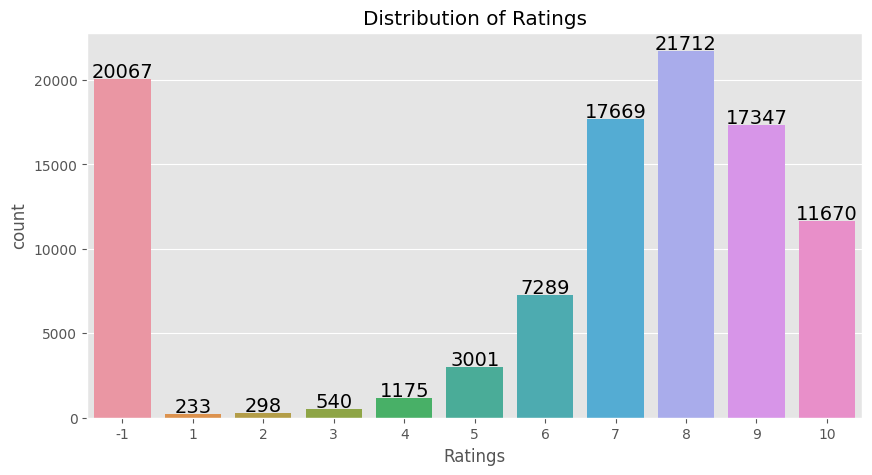

In [66]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=rating, x='rating')
labels = (rating['rating'].value_counts().sort_index())
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')

for i,v in enumerate(labels):
    ax.text(i, v+100, str(v), horizontalalignment='center', size=14, color='black')
plt.show()

In [67]:
anime_ratings = rating.merge(anime[["anime_id","name"]],how = "inner", on = "anime_id")

In [68]:
anime_ratings.head(n=10)

,user_id,anime_id,rating,name
0,1,20,-1,Naruto
1,3,20,8,Naruto
2,5,20,6,Naruto
3,6,20,-1,Naruto
4,10,20,-1,Naruto
5,21,20,8,Naruto
6,28,20,9,Naruto
7,34,20,9,Naruto
8,38,20,6,Naruto
9,39,20,10,Naruto


In [69]:
anime_ratings = anime_ratings[anime_ratings["rating"] >= 0]

In [70]:
anime_df = anime_ratings.pivot_table(index = "user_id", columns = "name", values = "rating")

In [71]:
anime_df.head()

name,009 ReCyborg,0091,07Ghost,11eyes,11eyes Momoiro Genmutan,11eyes Picture Drama,12sai,12sai Chicchana Mune no Tokimeki,15 Bishoujo Hyouryuuki,20dai no Heyahen,...,hackThe Movie Sekai no Mukou ni,hackUnison,hackVersus The Thanatos Report,iDOLMSTER Xenoglossia,sCRYed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
anime_df = pd.DataFrame(np.where(np.isnan(anime_df) == False,1,0),index = anime_df.index,columns=anime_df.columns)

In [73]:
anime_df.head()

name,009 ReCyborg,0091,07Ghost,11eyes,11eyes Momoiro Genmutan,11eyes Picture Drama,12sai,12sai Chicchana Mune no Tokimeki,15 Bishoujo Hyouryuuki,20dai no Heyahen,...,hackThe Movie Sekai no Mukou ni,hackUnison,hackVersus The Thanatos Report,iDOLMSTER Xenoglossia,sCRYed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
frequent_itemset = apriori(anime_df, min_support=0.007, use_colnames=True)

KeyboardInterrupt: ignored

In [ ]:
frequent_itemset.sort_values('support', ascending = False)

In [ ]:
rules = association_rules(frequent_itemset, metric="lift", min_threshold=2)
rules.sort_values('lift', ascending = False).head()

In [ ]:
def recommendations(rules,name):
  df_rem = rules[rules['antecedents'].apply(lambda x: len(x) ==1 and next(iter(x)) == name)]
  df_rem = df_rem[df_rem['lift'] > 2]
  df_rem.sort_values('confidence', ascending = False).head()